# Data load : set your target and unsused_features 


In [2]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score

test_data = pd.read_csv('./data/test.mor.con.csv')
train_data = pd.read_csv('./data/train.mor.con.csv')

target='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0']


# train data and valida data would be 75% and 25% of train data.

In [3]:

test_data_processed= test_data.fillna(0).reset_index(drop=True)
train_data_processed = train_data.fillna(0).reset_index(drop=True)


features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 

if "Set" not in train_data_processed.columns:
    train_data_processed["Set"] = np.random.choice(["train", "valid"] , p =[.75, .25], size=(train_data_processed.shape[0],))

train_indices = train_data_processed[train_data_processed.Set=="train"].index
valid_indices = train_data_processed[train_data_processed.Set=="valid"].index



# Split data 

In [6]:

X_train = train_data_processed[features].values[train_indices]
y_train = train_data_processed[target].values[train_indices]
X_valid = train_data_processed[features].values[valid_indices]
y_valid = train_data_processed[target].values[valid_indices]
X_test = test_data_processed[features].values
y_test = test_data_processed[target].values

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ",y_train.shape)
print("X_valid.shape: ", X_valid.shape)
print("y_valid.shape: ",y_valid.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape:  (5888, 4530)
y_train.shape:  (5888,)
X_valid.shape:  (1936, 4530)
y_valid.shape:  (1936,)
X_test.shape:  (1957, 4530)
y_test.shape:  (1957,)


# Hyperparameter tuning

In [8]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
# Store maximum auc
max_auc = 0
# Store maximum hypterparameter set
max_hy = []
# define hyperparameter space
n_ = [4,8,16]
lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
w_ = [0.01, 0.001, 0.0001]
g_ = [0.95, 0.99, 0.9]
ss_ = [10, 20, 30]
all_ = [n_, lr_, w_, g_, ss_]
h_space = [s for s in itertools.product(*all_)]
# Start training


for hy in tqdm(h_space):
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
    clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
    test_acc = accuracy_score(preds_acc, y_test)
    print("FINAL TEST SCORE", test_auc, test_acc)
    if test_auc>max_auc:
        max_hy = hy
        max_auc = test_auc


Device used : cuda
FINAL TEST SCORE 0.9351831913447969 0.8436382217680123
Device used : cuda
FINAL TEST SCORE 0.9293106151675117 0.8410832907511497
Device used : cuda
FINAL TEST SCORE 0.9323456854649036 0.8313745528870721
Device used : cuda
FINAL TEST SCORE 0.9289917942821302 0.8441492079713848
Device used : cuda
FINAL TEST SCORE 0.9297151518319134 0.8165559529892693
Device used : cuda
FINAL TEST SCORE 0.9315569957664767 0.7889626980071538
Device used : cuda
FINAL TEST SCORE 0.9280572832279308 0.8559018906489525
Device used : cuda
FINAL TEST SCORE 0.9287367375738254 0.8277976494634645
Device used : cuda
FINAL TEST SCORE 0.9314618721580515 0.8344404701073072
Device used : cuda
FINAL TEST SCORE 0.9223608425233888 0.8507920286152274
Device used : cuda
FINAL TEST SCORE 0.92071917629227 0.8446601941747572
Device used : cuda
FINAL TEST SCORE 0.9156227460408719 0.8431272355646398
Device used : cuda
FINAL TEST SCORE 0.9269272983849892 0.8599897802759325
Device used : cuda
FINAL TEST SCORE 0.92

# Do it with best hyperparameter 

In [9]:
hy = max_hy
clf = TabNetClassifier(n_a = hy[0],
                       n_d = hy[0],
                       optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                       scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=0
                           )
clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
preds_acc = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
test_acc = accuracy_score(preds_acc, y_test)
print("Best hy:", hy)
print("FINAL TEST SCORE", test_auc, test_acc)

Device used : cuda
FINAL TEST SCORE 0.9370386243662782 0.8559018906489525


# find important feature

In [10]:
def feature(num):
    importance =clf.feature_importances_
    plt.plot(importance)

    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (num):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    print(important_features.reset_index(drop=True))

                             feature name     ratio
0         rh_G_postcentral_thickness._.16  0.116739
1  rh_G_temp_sup.Plan_polar_meancurv._.15  0.092572
2            lh_lateraloccipital_area._.1  0.088251
3                 BrainSegVolNotVent._.13  0.078058
4             Right.Cerebellum.Cortex._.9  0.074026


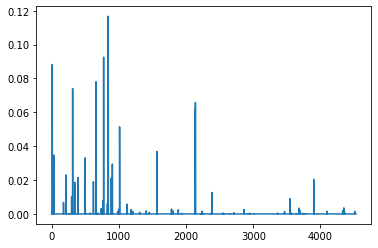

In [11]:
feature(5)

,feature name,ratio
0,rh_G_postcentral_thickness._.16,0.116739
1,rh_G_temp_sup.Plan_polar_meancurv._.15,0.092572
2,lh_lateraloccipital_area._.1,0.088251
3,BrainSegVolNotVent._.13,0.078058
4,Right.Cerebellum.Cortex._.9,0.074026


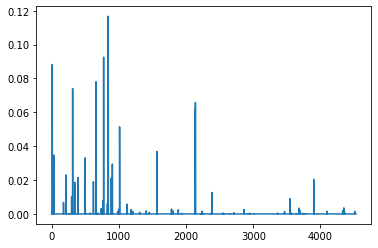

In [15]:
importance =clf.feature_importances_
plt.plot(importance)

labels_importance=importance.argsort()[::-1]

importance_sort = np.sort(importance)[::-1]

feat_name_sort=test_data_processed[features].columns[labels_importance]
important_features = pd.DataFrame() 


for i in range (5):
    feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
    important_features=pd.concat([important_features,feature])

important_features.reset_index(drop=True)